In [28]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random
import torch
import torch.nn as nn
import pandas as pd
#import hashlib
from torch import flatten
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.nn import ReLU,MaxPool2d,Linear,Conv2d,Module, Sequential, BatchNorm2d
import torch.nn.functional as F
from torchmetrics import ConfusionMatrix

In [30]:
def f_createRandomImage():
    x,y = 100,100
    max_r = 20
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((102, 204, 0),1),((0, 51, 204),2),((204, 0, 204),3),((204, 0, 0),4)]
    lst_res = []
    for color in colors:
        for i in range(500):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(10,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame.reshape(3,x,y),locx-r,locy-r,locx+r,locy+r, color[1]])
            #cv2.waitKey(0)

    return lst_res

In [31]:
class cls_data(Dataset):
    def __init__(self,df) -> None:
        super().__init__()

        self.dataset = df

        print("Head of dataset: ", self.dataset.head(2))
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "image"]), torch.tensor( [torch.tensor(self.dataset.loc[index, "cx1"]).float(),
            torch.tensor(self.dataset.loc[index, "cy1"]).float(),
            torch.tensor(self.dataset.loc[index, "cx2"]).float(),
            torch.tensor(self.dataset.loc[index, "cy2"]).float()]), torch.tensor(self.dataset.loc[index, "c"]).long()

In [32]:
class cls_model(nn.Module):

    def __init__(self):
        # call the parent constructor
        super(cls_model, self).__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=(5,5), bias=False)
        
        self.fc1 = nn.Linear(22*22*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        x = x.float()

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        

        #x = self.conv1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [33]:
lst_data = f_createRandomImage()
df1 = pd.DataFrame({"image":[i[0] for i in lst_data],"cx1":[i[1] for i in lst_data],"cy1":[i[2] for i in lst_data],"cx2":[i[3] for i in lst_data],"cy2":[i[4] for i in lst_data], "c":[i[5] for i in lst_data]})

df_train , df_test = train_test_split(df1,test_size=.1,stratify=df1.c)

ds_train = cls_data(df_train.reset_index().drop(columns=["index"]))

ds_test = cls_data(df_test.reset_index().drop(columns=["index"]))

trainLoader = DataLoader(ds_train,batch_size=8)
testLoader = DataLoader(ds_test,batch_size=8)

Head of dataset:                                                 image  cx1  cy1  cx2  cy2  c
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   28   52   68   92  0
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   21   34   45   58  0
Head of dataset:                                                 image  cx1  cy1  cx2  cy2  c
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   58   32   88   62  0
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   53    6   81   34  0


In [34]:
df_train.c.value_counts()

0    450
1    450
2    450
3    450
4    450
Name: c, dtype: int64

In [37]:
def f_train(net, trainLoader, valLoader, optim1, device):

    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()

    for ep in range(10):
        
        confmat = ConfusionMatrix(num_classes=5)
        for it , (batch, y, cl) in enumerate(trainLoader):
            optim1.zero_grad()
            
            batch,y = batch.to(device), y.to(device)
            
            logits = net(batch)

            confmat.update(logits[:,4:].softmax(dim=1), cl)
            
            
            loss1 = criterion1(logits[:,:4], y)
            
            loss2 = criterion2(logits[:,4:].softmax(dim=1), cl)
            
            
            loss = .1*loss1 + loss2
            loss.backward()

            optim1.step()
        print("loss1",loss1)
        print("loss2",loss2)
        print("Loss:", loss)
        print(confmat.confmat)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


net = cls_model()
net.to(device)


opti = Adam(net.parameters(),lr=5e-4)

f_train(net,trainLoader,testLoader,opti,device)

KeyboardInterrupt: ignored

In [12]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.randn(3, 5).softmax(dim=1)
#output = loss(input, target)
#output.backward()

In [40]:
for i in testLoader:
    #print(i[0])
    #print(i[0])
    print(i[0].shape)
    break
    predict= net(i[0].float())
    predict = predict.int().numpy()

    for im1,pred in zip(i[0],predict):
        im1 = im1*255
        im1 = im1.reshape((100,100,3)).int().numpy()
        
        cv2.rectangle(im1,(pred[0],pred[1]), (pred[2],pred[3]), (100,100,10))
        cv2_imshow(im1)
        cv2.waitKey(0)
    print(i[0][0].shape)
    
    

torch.Size([8, 3, 100, 100])


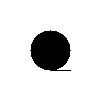

-1

In [2]:
frame = np.full((100,100),255,dtype="uint8")
#cv2.putText(frame,"1", (50,70),cv2.FONT_HERSHEY_PLAIN,1,(0,0,0))
im1 = cv2.circle(frame,(50,50),20,(0,0,0),-1)
cv2.line(frame,(50,70),(70,70),(0,255,0))
cv2_imshow(frame)
cv2.waitKey(0)

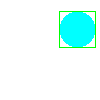

((255, 255, 0), 1)

In [3]:
x,y = 100,100
max_r = 20
rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
frame = np.full((x,y,3),255,dtype="uint8")

locx = random.randint(*rangex)
locy = random.randint(*rangey)
r = random.randint(10,max_r)
color = random.choice([((255, 255, 0),1),((102, 204, 0),2),((0, 51, 204),3),((204, 0, 204),4),((204, 0, 0),5)])
im1 = cv2.circle(frame,(locx,locy),r,color[0],-1)
cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
cv2_imshow(frame)
cv2.waitKey(0)
color